## Exploring Loss/Utility Functions in Point Prediction
We have not specified above what the action $a$ is. This is on purpose. Sometimes we want to make point predictions and the action $a$ is a single number (whatever we guess). Sometimes we want to find a distribution and the action is "guess distribution blah". Sometimes actions are literal actions like "do anoter test" or "keep the school oen". And sometimes we want to compare multiple models. We'll see these below...

For our first example, given a posterior predictive distribution, how do you communicate one number to your boss from it? How do you make a point-prediction?

### The squared error loss/utility
The squared error is an example of a risk defined to make a point estimate.  It decides that that the loss of saying the value "a" to our boss is the square or our distance from what the distribution actually spits out ($y^*$). (Our boss is more much more annoyed by large errors than small ones)

$$l(a, y^*) = (a - y^*)^2$$

The average loss across all possible $y^*$ is then:

$$\bar{l}(a) = \int (a - y^*)^2 \, p(y^* \vert D, M) dy^*$$

If we find the value of a that minimizes the above, the optimal point prediction (under this loss) is the mean of the posterior predictive distribution:

$$\hat{a} = E_p[y^*].$$

How much do we expect to lose, on average, under this rule? It turns out to be the average squared distance from the average, or the variance.

$$\bar{l}(\hat{a}) = \int dy^* \, (\hat{a} - y^*)^2 \, p(y^* \vert D, M) = \int dy^* \, (E_p[y^*] - y^*)^2 \, p(y^* \vert D, M) = Var_p[y^*]$$

### Custom utility: Stock Market Returns

This is a regression example.

We generate some data to have returns as a function of stock price or trading signals. We generate it as a line with noise, which is perhaps the most unlikely stock market signal...:-)

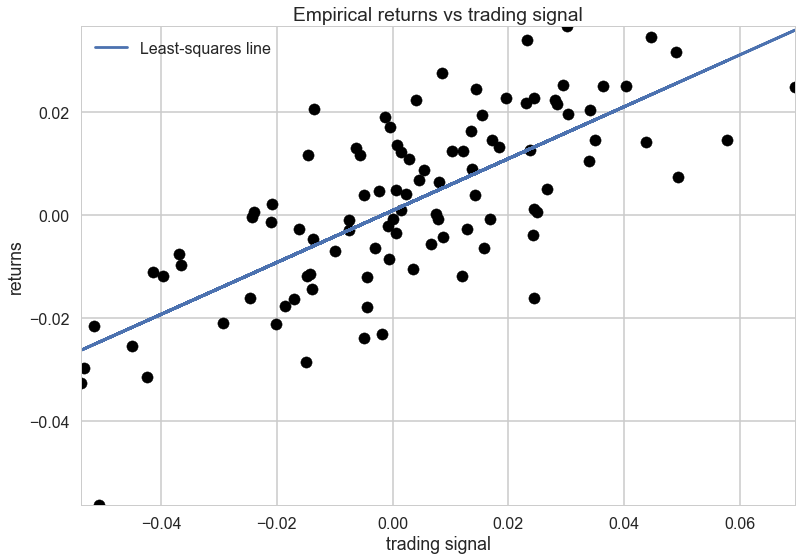

In [2]:
## Code to create artificial data
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N) 

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label = "Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");


A squared-error loss is agnostic to too-high versus too low. A realized value of 0.01 and a prediction of -0.01 is measured to be as bad a prediction of 0.03:

$$(0.01−(−0.01))^2=(0.01−0.03)^2=0.004$$

In the trading context, getting the sign wrong (and thus buying when you should sell or vice versa) is arguably worse than simply getting the magnitude wrong. So we might want to define a loss that is asymmetric.

Notice that the loss is quadratic when the sign is different, as this will create an even higher penalty. There is still a penalty for guessing wrong with the same sign, since you will overcommit money that could have been used more usefully elsewhere.

In [3]:
def stock_loss(stock_return, pred, alpha = 100.):
    if stock_return * pred < 0:
        #opposite signs, not good
        return alpha*pred**2 - np.sign(stock_return)*pred \
                        + abs(stock_return) 
    else:
        return abs(stock_return - pred)

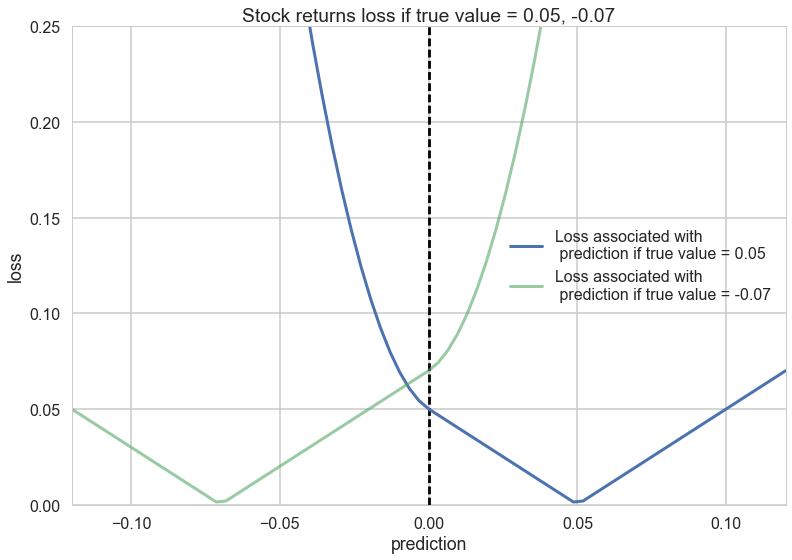

In [8]:
true_value = .05
pred = np.linspace(-.12, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], \
        label = "Loss associated with\n prediction if true value = 0.05", lw =3) 
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.12, .12)
plt.ylim(0, 0.25)

true_value = -.07
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = 0.6, \
        label = "Loss associated with\n prediction if true value = -0.07", lw =3) 
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.07");

Notice how the loss changes from linear to quadratic after you cross the 0 line and start getting the sign wrong.

Let us fit our returns model

In [9]:
import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]  

INFO (theano.gof.compilelock): Refreshing lock C:\Users\Will\AppData\Local\Theano\compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.6.0-64\lock_dir\lock


ImportError: DLL load failed: A dynamic link library (DLL) initialization routine failed.

In [ ]:
pm.plots.traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"]);

We seem to have converged. Now, the game is to find a point estimate y from the predictive samples at each point(`possible_outcomes`) that minimizes the stock loss, instead of the standard least squares line which is just the mean of the posterior predictive.

In [ ]:
from scipy.optimize import fmin


def stock_loss(price, pred, coef = 500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals =  np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = fmin(tomin, 0, disp = False)
        
        
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label ="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left");

The plot above takes the posterior-predictive distribution at each trading signal, applies the risk to it by calculating the integral as a mean over posterior-predictive samples. Then we minimize over the action $a$ which here is a prediction at each trading signal. This is plotted as the green line above. Notice that when the signal is close to 0, our prediction is close to 0, we take no position as its very easy for the sign to be different. Far away from 0, we approach the squared risk more...